<center><h3>Projeto Tera - Precificação de imóveis em Teresina</h3></center>

A precificação de um imóvel é um dos principais critérios a ser levado em consideração na hora da compra de um imóvel, seja ele para moradia ou para investimento, portanto quem está vendendo precisa analisar bem ao formatar o preço já que isso influencia bastante a quantidade de pessoas que terão interesse pelo imóvel e, ou mesmo qual será a linha de crédito utilizada, consequentemente, as oportunidades de iniciar uma negociação. A mesma lógica é aplicada para preços de aluguéis.

Nosso objeto de pesquisa foram os imóveis da cidade de Teresina, localizada ao Nordeste do Brasil. A cidade não tem praia, poucas opções turísticas, mas terrenos tão caros quanto de cidades maiores como Fortaleza e Salvador. Por isso decidimos entender mais o cenário geral e fazer análises de dados para responder às seguintes perguntas:

1. Como é a distribuição de preços de imóveis a venda na cidade?
2. Quais são as zonas mais caras e mais baratas?
**3. Quais características mais influenciam no preço no dataset e por bairro?**
4. Como filtrar imóveis que atendam as necessidades de uma pessoa que deseja comprar para moradia?

Nossa abordagem foi dividida nas seguintes etapas:

* **Obtendo dados :** usando Python, consegui extrair dados de apartamentos alugados de alguns sites holandeses.
* **Limpeza de dados:** geralmente é a parte mais longa de qualquer processo de análise de dados. Nesse caso, era importante limpar os dados para lidar adequadamente com os formatos de dados, remover valores discrepantes etc.
* **EDA:** algumas análises de Análise Exploratória de Dados para visualizar e entender melhor nossos dados.
* **Análise Preditiva :** tentaremos prever preços de aluguel usando um modelo treinado com nosso conjunto de dados.
* **Engenharia de recursos :** nesta etapa, vamos brincar um pouco com o conjunto de dados e adicionar mais recursos para tornar nosso modelo mais preciso.



#  Imports

In [207]:



import math
import numpy as np
import pandas as pd
import random
import warnings

import re

import pickle


from matplotlib import pyplot as plt
import plotly.express as px
import seaborn as sns

#Feature selection
from boruta                import BorutaPy


# preprocessing
from sklearn.preprocessing import LabelEncoder

from sklearn.model_selection import train_test_split

from yellowbrick.features import Rank1D


# Stats libs
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.formula.api as smf

#data transformation
from sklearn.preprocessing import RobustScaler, MinMaxScaler, LabelEncoder



#modelling
from sklearn.ensemble      import RandomForestRegressor
from sklearn.linear_model  import LinearRegression, Lasso
import xgboost as xgb
from sklearn import ensemble as en


#metrics
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error, mean_absolute_error


from IPython.display import display
pd.options.display.max_columns = None

warnings.filterwarnings( 'ignore' )



## 0. Helper Functions

In [256]:
# métricas

def ml_error( model_name, y, yhat ):
    mean_y = np.mean(y)
    mean_pred = np.mean(yhat)
    r2 = r2_score(y, yhat)
    mae = mean_absolute_error( y, yhat )
    mape = mean_absolute_percentage_error( y, yhat )
    rmse = np.sqrt( mean_squared_error( y, yhat ) )
    
    return pd.DataFrame( { 'Model Name': model_name, 
                          "MEAN": mean_y,
                          "MEAN_yhat": mean_pred,
                          "R2": r2,
                           'MAE': mae, 
                           'MAPE': mape,
                           'RMSE': rmse }, index=[0] )

def cross_validation_report(X_train, y_train, model, dataset_name ,kfold, verbose=False):
    mae_list = []
    mape_list = []
    rmse_list = []
    
    mean_y_list = []
    mean_pred_list = []
    r2_list = []
    
    for k in reversed( range( 1, kfold+1 ) ):
        if verbose:
            print( '\nKFold Number: {}'.format( k ) )
            
        # training and validation dataset
        X_train, xvalidation, y_train, yvalidation = train_test_split(X_train, y_train, test_size=0.25, random_state=1) # 0.25 x 0.8 = 0.2

        # model
        m = model.fit( X_train, y_train )
            
         
        
        # prediction
        yhat = m.predict( xvalidation )

        # performance
        m_result = ml_error( dataset_name, np.expm1( yvalidation ), np.expm1( yhat ) )
        

        # store performance of each kfold iteration
        
        mae_list.append(  m_result['MAE'] )
        mape_list.append( m_result['MAPE'] )
        rmse_list.append( m_result['RMSE'] )
        mean_y_list.append( m_result['MEAN'] )
        mean_pred_list.append( m_result['MEAN_yhat'] )
        r2_list.append( m_result['R2'] )
        
    #print((mae_list))

    return pd.DataFrame( {'Model Name': dataset_name,
        'MEAN CV': np.round( np.mean( mean_y_list ), 2 ).astype( str ) + ' +/- ' + np.round( np.std( mean_y_list ), 2 ).astype( str ) ,
        'MEAN PRED CV': np.round( np.mean( mean_pred_list ), 2 ).astype( str ) + ' +/- ' + np.round( np.std( mean_pred_list ), 2 ).astype( str ),
        'R2 CV': np.round( np.mean(  r2_list ), 2 ).astype( str ) + ' +/- ' + np.round( np.std(  r2_list), 2 ).astype( str ),
        'MAE CV': np.round( np.mean( mae_list ), 2 ).astype( str ) + ' +/- ' + np.round( np.std( mae_list ), 2 ).astype( str ),
        'MAPE CV': np.round( np.mean( mape_list ), 2 ).astype( str ) + ' +/- ' + np.round( np.std( mape_list ), 2 ).astype( str ),
        'RMSE CV': np.round( np.mean( rmse_list ), 2 ).astype( str ) + ' +/- ' + np.round( np.std( rmse_list ), 2 ).astype( str ) }
                        , index=[0] )
    
    


#Função para calcular o VIF
def calc_vif(df):
  """ 
    Variable Inflation Factors
    VIF determines the strength of the correlation between the independent variables. It is predicted by taking a variable and regressing it against every other variable.
    Reference: https://www.analyticsvidhya.com/blog/2020/03/what-is-multicollinearity/#:~:text=Fixing%20Multicollinearity-,What%20is%20Multicollinearity%3F,variable%20in%20a%20regression%20model.
  """
  # Calculating VIF
  vif = pd.DataFrame()
  vif["variables"] = df.columns
  vif["VIF"] = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]

  return(vif)

#Função para plotar o VIF
def plot_vif(vif):
  print('vars: ', list(vif.columns))
  print('Variable Inflation Factors:', vif.VIF.sum(), '\n')


#  1. Loading data
Estamos usando o dataset em salvo em csv que esta salvo no GitHUb. Para isso tivemos que deixar o repositorio publico. Desse modo todos irao ter acesso a base de dados consolidada.

In [28]:
from traitlets.traitlets import Unicode
df_raw = pd.read_csv('https://raw.githubusercontent.com/reznorcode/ml-real-state-predictive-modeling/main/consolidadoV3.csv')
#df_raw= pd.read_excel('consolidado.xlsx')

Olhando a "cara" do dataset. Caso queirao ver mais linhas e so informar entre parenteses a quantidade de linhas que deseja visualizar.

Observamos aqui que as colunas Quarto, Banheiros e Vagas em alhgumas linhas informa que ha "5 ou mais". teremos que tratar essas colunas mais a frente. Tambem ha algumas colunas com valores NaN


In [29]:
df_raw.head()

,Categoria,Area construida,Preço,Quartos,Banheiros,Vagas,Bairro
0,Apartamentos,210m²,1100000.0,3,4,4,Fátima
1,Apartamentos,50m²,115000.0,2,1,1,Vale do Gavião
2,Casas,210m²,1450000.0,4,5 ou mais,4,Gurupi
3,Casas,140m²,690000.0,4,4,2,Zoobotânico
4,Casas,66m²,110000.0,2,2,1,NaN


# 2. Data Description

In [30]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2921 entries, 0 to 2920
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Categoria        2921 non-null   object 
 1   Area construida  2921 non-null   object 
 2   Preço            2683 non-null   float64
 3   Quartos          2919 non-null   object 
 4   Banheiros        2919 non-null   object 
 5   Vagas            2828 non-null   object 
 6   Bairro           2679 non-null   object 
dtypes: float64(1), object(6)
memory usage: 159.9+ KB


## 2.1 NA

Precisamos decidir o que faremos principalmente com as linhas que nao tem preco e bairro. Temos que observar se a diferenca de valor entre os bairros sao muito elevadas para entao ver como preencheremos essas celulas.

In [31]:
df_raw.isna().mean()*100

Categoria          0.000000
Area construida    0.000000
Preço              8.147895
Quartos            0.068470
Banheiros          0.068470
Vagas              3.183841
Bairro             8.284834
dtype: float64

In [32]:
print( 'Temos {} imoveis em nosso dataset'.format( df_raw.shape[0] ) )
print( 'Temos por enquanto {} caracteristicas desses imoveis'.format( df_raw.shape[1] ) )

Temos 2921 imoveis em nosso dataset
Temos por enquanto 7 caracteristicas desses imoveis


## 2.2 Check for misplaced values/ rearrange

In [33]:
df = df_raw

In [34]:
# Rearrumando o Bairro que estava em coluna errada, replace Vagas pela mais comum
df.loc[df.Vagas == 'Morros', 'Bairro' ] = 'Morros'


df.loc[df.Vagas == 'Ininga', 'Bairro' ] = 'Ininga'
df.loc[df.Vagas == 'Uruguai', 'Bairro' ] = 'Uruguai'
df.loc[df.Vagas == 'São Cristóvão', 'Bairro' ] = 'São Cristóvão'
df.loc[df.Vagas == 'Fátima', 'Bairro' ] = 'Fátima'
df.loc[df.Vagas == 'Horto', 'Bairro' ] = 'Horto'
df.loc[df.Vagas == 'Gurupi', 'Bairro' ] = 'Gurupi'
df.loc[df.Vagas == 'Vale Quem Tem', 'Bairro' ] = 'Vale Quem Tem'
df.loc[df.Vagas == 'São João', 'Bairro' ] = 'São João'
df.loc[df.Vagas == 'Jóquei', 'Bairro' ] = 'Jóquei'
df.loc[df.Vagas == 'Santa Isabel', 'Bairro' ] = 'Santa Isabel'
df.loc[df.Vagas == 'Itararé', 'Bairro' ] = 'Itararé'
df.loc[df.Vagas == 'Ilhotas', 'Bairro' ] = 'Ilhotas'
df.loc[df.Vagas == 'Cristo Rei', 'Bairro' ] = 'Cristo Rei'
df.loc[df.Vagas == 'Recanto das Palmeiras', 'Bairro' ] = 'Recanto das Palmeiras'
df.loc[df.Vagas == 'Macaúba', 'Bairro' ] = 'Macaúba'
df.loc[df.Vagas == 'Tabajaras', 'Bairro' ] = 'Tabajaras'
df.loc[df.Vagas == 'Santa Maria', 'Bairro' ] = 'Santa Maria'
df.loc[df.Vagas == 'Piçarra', 'Bairro' ] = 'Piçarra'
df.loc[df.Vagas == 'Samapi', 'Bairro' ] = 'Samapi'
df.loc[df.Vagas == 'Saci', 'Bairro' ] = 'Saci'
df.loc[df.Vagas == 'Noivos', 'Bairro' ] = 'Noivos'
df.loc[df.Vagas == 'Satélite', 'Bairro' ] = 'Satélite'
df.loc[df.Vagas == 'Cabral', 'Bairro' ] = 'Cabral'
df.loc[df.Vagas == 'Novo Uruguai', 'Bairro' ] = 'Novo Uruguai'
df.loc[df.Vagas == 'Zoobotânico', 'Bairro' ] = 'Zoobotânico'
df.loc[df.Vagas == 'Mocambinho', 'Bairro' ] = 'Mocambinho'
df.loc[df.Vagas == 'Planalto', 'Bairro' ] = 'Planalto'
df.loc[df.Vagas == 'Acarape', 'Bairro' ] = 'Acarape'
df.loc[df.Vagas == 'Pirajá', 'Bairro' ] = 'Pirajá'
df.loc[df.Vagas == 'Pedra Mole', 'Bairro' ] = 'Pedra Mole'
df.loc[df.Vagas == 'Centro', 'Bairro' ] = 'Centro'
df.loc[df.Vagas == 'Campestre', 'Bairro' ] = 'Campestre'
df.loc[df.Vagas == 'Água Mineral', 'Bairro' ] = 'Água Mineral'
df.loc[df.Vagas == 'Vale do Gavião', 'Bairro' ] = 'Vale do Gavião'
df.loc[df.Vagas == 'Morada do Sol', 'Bairro' ] = 'Morada do Sol'
df.loc[df.Vagas == 'Cidade Jardim', 'Bairro' ] = 'Cidade Jardim'
df.loc[df.Vagas == 'Porto do Centro', 'Bairro' ] = 'Porto do Centro'
df.loc[df.Vagas == 'Colorado', 'Bairro' ] = 'Colorado'
df.loc[df.Vagas == 'Memorare', 'Bairro' ] = 'Memorare'
df.loc[df.Vagas == 'São Pedro', 'Bairro' ] = 'São Pedro'
df.loc[df.Vagas == 'Aeroporto', 'Bairro' ] = 'Aeroporto'



# 5 ou mais 
df.loc[df.Vagas == '5 ou mais', 'Vagas' ] = 5



In [35]:
# Vagas as que estavam como o Bairro mudar para as mais comuns/moda
df['Vagas'] = df.Vagas.apply(lambda x: x if type(x) == float else
                                     x if x == 5 else
                               int(x) if x.isnumeric()  
                               else df.Vagas.value_counts().index[0]             
                  )


# Fillna Vagas - Mais COmun
df.Vagas.fillna(df.Vagas.value_counts().index[0], inplace=True)

In [36]:
df.Quartos.value_counts(normalize=True)

3            0.492977
4            0.226105
2            0.224392
5 ou mais    0.036999
1            0.019185
0            0.000343
Name: Quartos, dtype: float64

In [37]:
# Quartos 5 ou mais  == 5
df.loc[df.Quartos == '5 ou mais', 'Quartos' ] = 5
df.loc[df.Banheiros == '5 ou mais', 'Banheiros' ] = 5

# Quarto == 0 , moda
df.loc[df.Quartos == 0, 'Quartos' ] = df.Quartos.value_counts().index[0]


- Explorar qual a variação dos imoveis descritos com 5 ou mais quartos e banheiros

In [38]:
aux_quartos_banheiros_5_ou_mais = df[df.Quartos == 5][df.Banheiros == 5]
print("""Temos {} imóveis com 5 ou mais quartos e banheiros, 
        representando {} % da base atual """.format(aux_quartos_banheiros_5_ou_mais.shape[0] , round(aux_quartos_banheiros_5_ou_mais.shape[0]/ df.shape[0] *100, 2)  ) ) 
      

Temos 79 imóveis com 5 ou mais quartos e banheiros, 
        representando 2.7 % da base atual 


In [39]:
aux_quartos_banheiros_5_ou_mais.head(4)

,Categoria,Area construida,Preço,Quartos,Banheiros,Vagas,Bairro
24,Casas,218m²,750000.0,5,5,5,Ininga
55,Casas,351m²,850000.0,5,5,5,Centro
61,Apartamentos,250m²,1300000.0,5,5,1,Centro
85,Casas,350m²,850000.0,5,5,4,Ininga


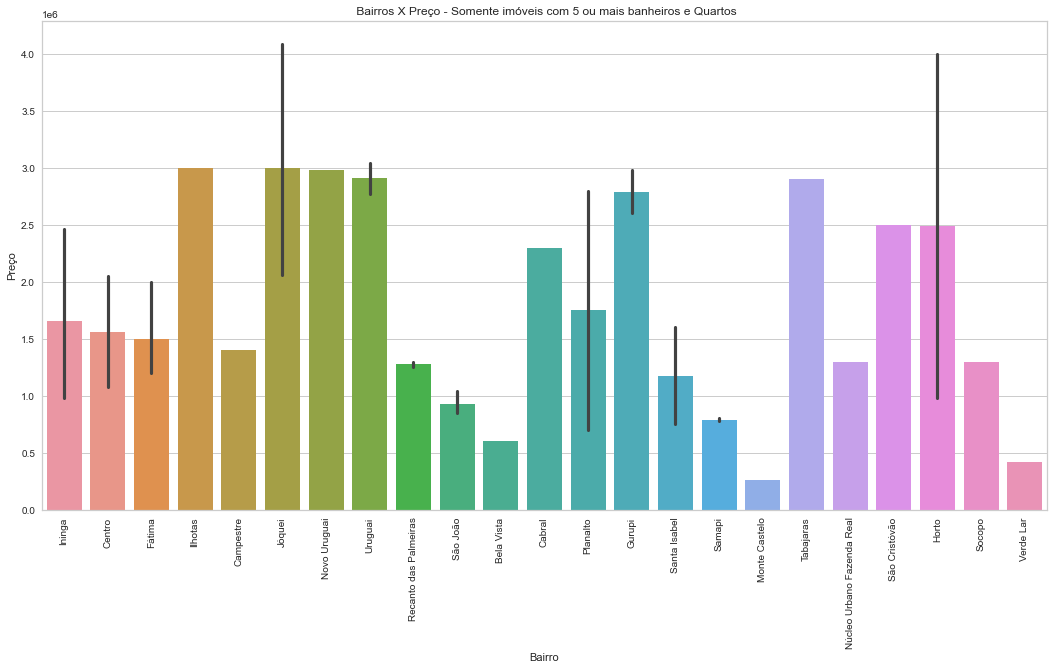

In [40]:
fig = plt.subplots(figsize = (18,9))

sns.barplot( x='Bairro', y='Preço', data=aux_quartos_banheiros_5_ou_mais);
plt.title(" Bairros X Preço - Somente imóveis com 5 ou mais banheiros e Quartos");
plt.xticks(rotation=90);

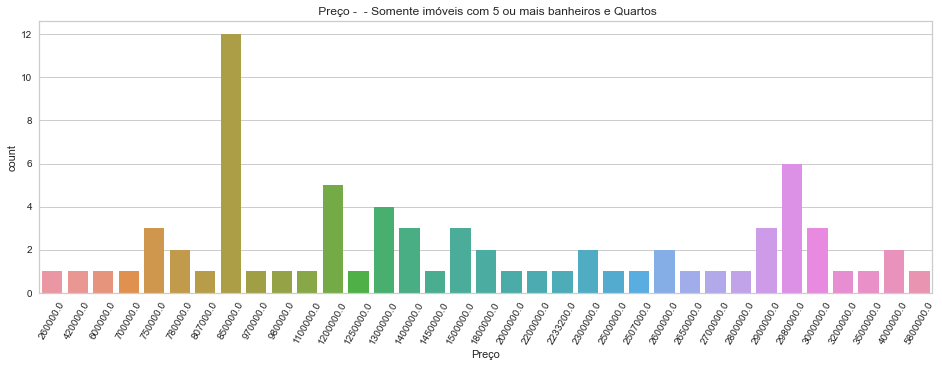

In [41]:
fig = plt.subplots(figsize = (16,5))

sns.countplot( x ='Preço', data=aux_quartos_banheiros_5_ou_mais);
plt.title(" Preço -  - Somente imóveis com 5 ou mais banheiros e Quartos");
plt.xticks(rotation=60);


In [42]:
aux_quartos_banheiros_5_ou_mais[(aux_quartos_banheiros_5_ou_mais.Preço >= 850000) & (aux_quartos_banheiros_5_ou_mais.Preço <950000)]

,Categoria,Area construida,Preço,Quartos,Banheiros,Vagas,Bairro
55,Casas,351m²,850000.0,5,5,5,Centro
85,Casas,350m²,850000.0,5,5,4,Ininga
878,Casas,287m²,850000.0,5,5,4,São João
880,Casas,287m²,850000.0,5,5,4,São João
1377,Casas,287m²,850000.0,5,5,2,São João
1383,Casas,287m²,850000.0,5,5,2,São João
1823,Casas,287m²,850000.0,5,5,4,São João
1989,Casas,287m²,850000.0,5,5,4,São João
1991,Casas,287m²,850000.0,5,5,4,São João
2407,Casas,287m²,850000.0,5,5,4,São João


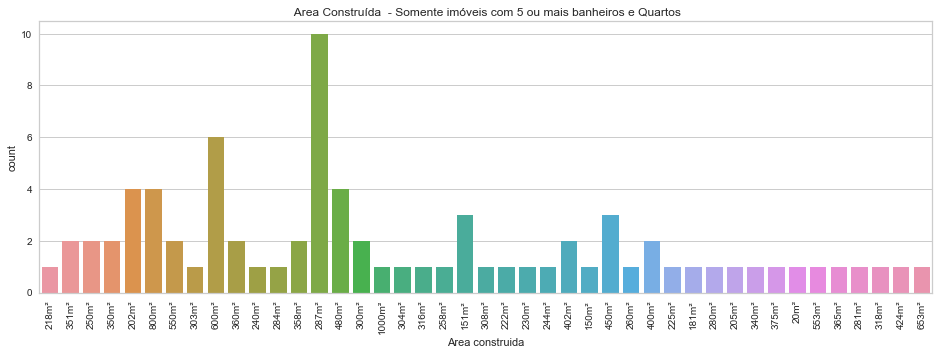

In [43]:
fig = plt.subplots(figsize = (16,5))

sns.countplot( x='Area construida', data=aux_quartos_banheiros_5_ou_mais);
plt.title(" Area Construída  - Somente imóveis com 5 ou mais banheiros e Quartos");
plt.xticks(rotation=90);

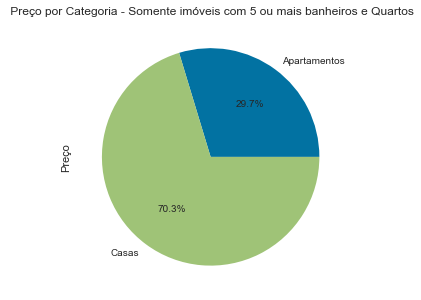

In [44]:
fig = plt.subplots(figsize = (16,5))

aux_cat = aux_quartos_banheiros_5_ou_mais.groupby("Categoria")["Preço"].sum()
aux_cat.plot.pie(autopct="%.1f%%");
plt.title(" Preço por Categoria - Somente imóveis com 5 ou mais banheiros e Quartos");


### 2.3 Fill NA

- Será que ocorrem em esgistros iguais?

In [45]:
df.isna().mean()*100

Categoria          0.000000
Area construida    0.000000
Preço              8.147895
Quartos            0.068470
Banheiros          0.068470
Vagas              0.000000
Bairro             2.841493
dtype: float64

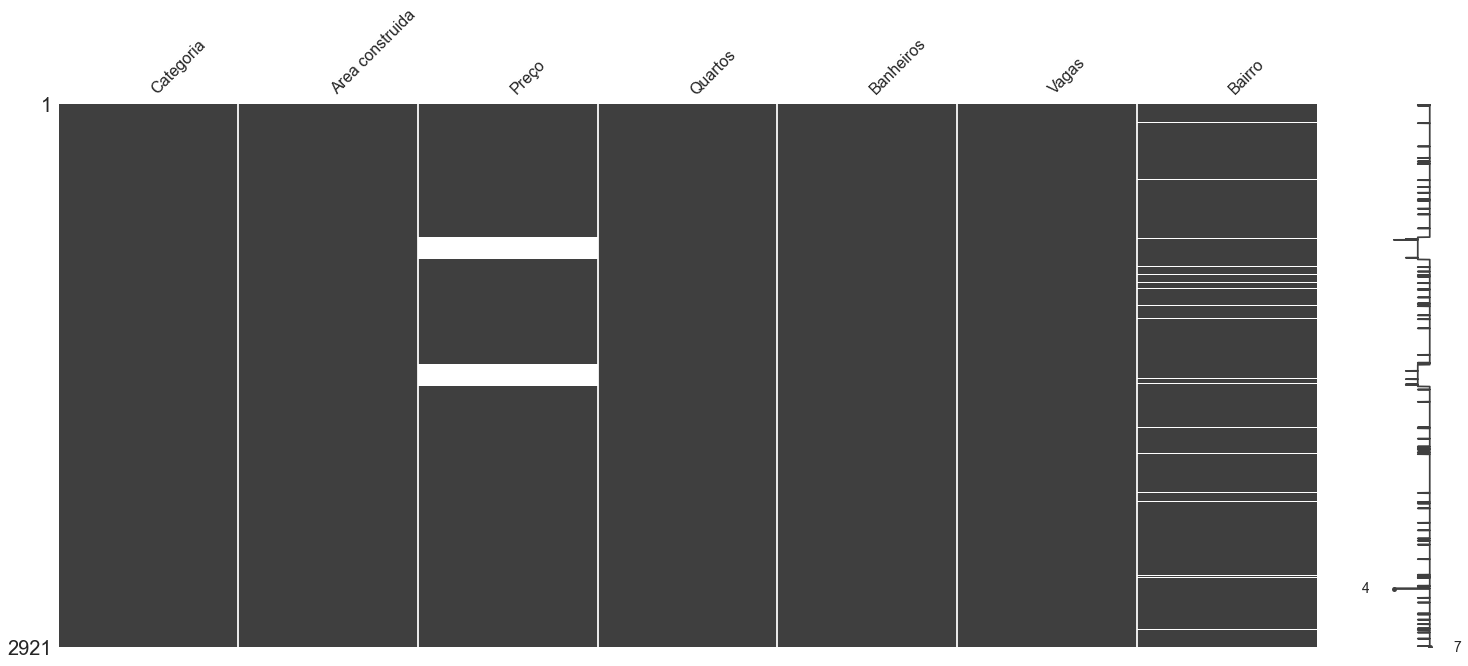

In [46]:
import missingno as msno
msno.matrix(df)
plt.show()

In [47]:
# Em Bairro são 75 dados faltantes, irá impactar o % se colocar em algum bairro
df.Bairro.value_counts()[:10]

Jóquei           241
Uruguai          231
Fátima           180
Ininga           174
Morros           167
Gurupi           158
Santa Isabel     142
São Cristóvão    135
Horto            129
Vale Quem Tem     78
Name: Bairro, dtype: int64

In [48]:
# Preço é nossa variável target - Fazer imputações nessa variável pode levar a viés 
# Filtrar os Preços Nulos

df = df[df.Preço.notnull() & df.Bairro.notnull()]


In [49]:
df.shape

(2608, 7)

In [50]:
df.isna().mean()*100

Categoria          0.0
Area construida    0.0
Preço              0.0
Quartos            0.0
Banheiros          0.0
Vagas              0.0
Bairro             0.0
dtype: float64

### 2.4 Data replace

In [51]:
# Removendo o m2 de Area Construída
regex = '\d+'
df['Area construida'] = df['Area construida'].apply(lambda x: re.match( regex, x ).group(0) if re.match( regex, x ) else x)

# Area construida está area murada == 0
#df.loc[df['Area construida'] == 'Área murada', 'Area construida'] = 0

In [52]:
df[df['Area construida'] == 0]

,Categoria,Area construida,Preço,Quartos,Banheiros,Vagas,Bairro


#Criar funcao para excluir dados inconsistente com a realidade.

### 2.5 Change dtypes

In [53]:
# Mudar dtype 
df['Vagas'] = df.Vagas.astype(int)
df['Banheiros'] = df.Banheiros.astype(int)
df['Quartos'] = df.Quartos.astype(int)
df['Area construida'] = df['Area construida'].astype(float)


df['Preço'] = df['Preço'].astype(float)

# convertendo os dados para categóricos
for c in df.select_dtypes(include=['object']):
    df[c] = df[c].astype('category')
    



###  2.6 Descriptive Statistics



#Next: Criar coluna de metro quadrado dividindo o preco pela area construida



###### 2.6.1 Numerical Attributes

#Next: Para as celulas de preco faltante agrupar por bairro e numero de quartos e usar a media. 

In [54]:
df.describe(percentiles = [.25, .5, .75, .95, .99]).round(2).T

,count,mean,std,min,25%,50%,75%,95%,99%,max
Area construida,2608.0,264.60,5110.57,10.0,68.0,103.0,200.0,400.0,800.0,260000.0
Preço,2608.0,690818.23,783284.57,0.0,265000.0,449900.0,850000.0,2000000.0,3093000.0,23000000.0
Quartos,2608.0,3.04,0.81,0.0,3.0,3.0,4.0,4.0,5.0,5.0
Banheiros,2608.0,2.64,1.33,1.0,2.0,2.0,4.0,5.0,5.0,5.0
Vagas,2608.0,2.13,1.18,0.0,1.0,2.0,3.0,5.0,5.0,5.0


- Preço e área construída com muita diferença do máximo - filtrar? outlier?
- Area construida igual a duzentos e sessenta mil ´e um sitio ou um erro que devemos excluir?
- O que devemos fazer com os precos que estao igual a zero, lembrando que eles representam 8%?


Para analise de preco de imoveis e interessante sabermos o valor do metro quadrado de cada imovel. Isso pode ser util mais na frente.

 


In [55]:
df[df['Area construida'] > 800]

,Categoria,Area construida,Preço,Quartos,Banheiros,Vagas,Bairro
173,Casas,260000.0,940000.0,3,4,5,Morada do Sol
483,Casas,900.0,2000000.0,3,2,2,Ininga
656,Casas,1020.0,400000.0,3,2,2,Saci
956,Casas,1000.0,2800000.0,5,5,5,Planalto
968,Apartamentos,5511.0,170000.0,2,2,1,Todos os Santos
1278,Casas,1250.0,1800000.0,4,1,5,Planalto
1294,Casas,1200.0,680000.0,4,1,3,Matinha
1523,Casas,1080.0,400000.0,3,2,2,Cidade Jardim
1806,Apartamentos,1012.0,370000.0,2,2,1,São Cristóvão
1934,Casas,22000.0,20000.0,1,1,0,Promorar


#Inserindo coluna preco_por_metro

In [56]:
df['preco_por_metro'] = round(df['Preço']/df['Area construida'])

df.head()

,Categoria,Area construida,Preço,Quartos,Banheiros,Vagas,Bairro,preco_por_metro
0,Apartamentos,210.0,1100000.0,3,4,4,Fátima,5238.0
1,Apartamentos,50.0,115000.0,2,1,1,Vale do Gavião,2300.0
2,Casas,210.0,1450000.0,4,5,4,Gurupi,6905.0
3,Casas,140.0,690000.0,4,4,2,Zoobotânico,4929.0
5,Casas,260.0,795000.0,3,4,2,Santa Lia,3058.0


- Dados Categoricos: Categoria, Bairro
- Dados Discretos: Quartos, Banheiros, Vagas
- Daods Continuos: Area construida, Preco, Preco por metro

#Inserindo coluna Zona

In [57]:

Leste = ['Jóquei', 'Jockey', 'Fátima', 'Horto', 'São Cristóvão', 'Ininga', 
'Santa Isabel', 'Morada do Sol', 'Noivos', 'Morros', 'Campestre', 'Pedra Mole', 
'Cidade Jardim', 'Novo Uruguai', 'Piçarreira', 'Planalto', 'Porto do Centro', 
'Samapi', 'Santa Lia', 'Satélite', 'Socopó', 'Tabajaras', 'Uruguai', 
'Vale do Gavião', 'Vale Quem Tem', 'Verde Lar', 'Árvores Verdes', 'São João', 
'Zoobotânico', 'Recanto das Palmeiras']


    
Sudeste = ['Beira Rio', 'Bom Princípio', 'Colorado', 'Comprida', 'Extrema', 
'Flor do Campo', 'Gurupi', 'Itararé', 'Livramento', 'Novo Horizonte', 
'Parque Ideal', 'Parque Poti', 'Redonda', 'Renascença', 'São Raimundo', 
'São Sebastião', 'Tancredo Neves', 'Todos os Santos', 'Verde Cap']

Sul = ['Angelim', 'Angélica', 'Areias', 'Bela Vista', 'Brasilar', 'Catarina', 
'Cidade Nova', 'Cristo Rei', 'Distrito Industrial', 'Esplanada',
'Lourival Parente', 'Macaúba', 'Monte Castelo', 'Morada Nova', 'Parque Jacinta', 
'Parque Juliana', 'Parque Piauí', 'Parque São João', 'Parque Sul', 'Pedra Miúda', 
'Pio XII', 'Portal Da Alegria', 'Promorar', 'Redenção', 'Saci', 'Santa Cruz',
'Santa Luzia', 'Santo Antônio', 'São Lourenço', 'São Pedro', 'Tabuleta', 
'Três Andares', 'Triunfo', 'Vermelha', 'Nossa Senhora Das Graças']

Norte = ['Aroeiras', 'Acarape', 'Aeroporto', 'Água Mineral', 'Alegre'
'Alto Alegre', 'Parque Alvorada', 'Bom Jesus', 'Buenos Aires', 'Cidade Industrial', 
'Embrapa', 'Itaperu', 'Parque Brasil', 'Mafrense', 'Mafuá', 'Matadouro', 'Memorare', 
'Monte Verde', 'Mocambinho', 'Morro da Esperança', 'Nova Brasília', 'Olarias'
'Poti Velho', 'Primavera', 'Real Copagre', 'Santa Maria da Codipe', 'Santa Rosa', 
'São Joaquim', 'Chapadinha', 'Jacinta Andrade', 'Pirajá', 'Vila São Francisco']

Centro = ['Cabral', 'Centro Norte', 'Centro Sul', 'Porenquanto', 'Vila Operária', 
'Matinha', 'Ilhotas', 'Frei Serafim', 'Marquês', 'Piçarra']




In [58]:
df["zona"] = df.Bairro.apply(lambda x: "Leste" if x in Leste else 
                     "Norte" if x in Norte
                     else "Centro" if x in Centro else
                     "Sul" if x in Sul
                     else "na")


In [59]:
df.zona.value_counts(normalize=True)

Leste     0.719325
na        0.136503
Sul       0.075920
Norte     0.036810
Centro    0.031442
Name: zona, dtype: float64

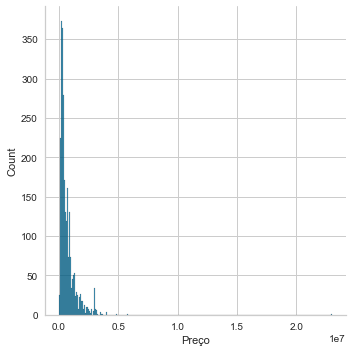

In [60]:
sns.displot(df['Preço']);

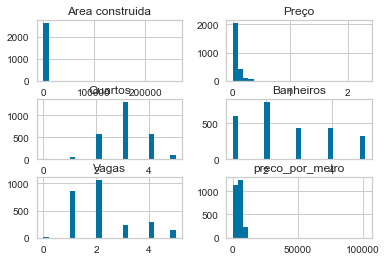

In [61]:

df.hist(bins = 25);

#### 2.6.2 Categorical Attributes

In [62]:
df.describe(include= 'category').T


,count,unique,top,freq
Categoria,2608,2,Apartamentos,1549
Bairro,2608,103,Jóquei,226


In [63]:
# Percentual de cada Categoria
df.Categoria.value_counts(normalize=True)

Apartamentos    0.593942
Casas           0.406058
Name: Categoria, dtype: float64

In [64]:
# Percentual nos 10 primeiros bairros
df.Bairro.value_counts(normalize=True)[:10]

Jóquei           0.086656
Uruguai          0.078604
Fátima           0.064417
Ininga           0.059816
Morros           0.056365
Gurupi           0.053298
Santa Isabel     0.051764
São Cristóvão    0.047163
Horto            0.046779
Vale Quem Tem    0.026840
Name: Bairro, dtype: float64

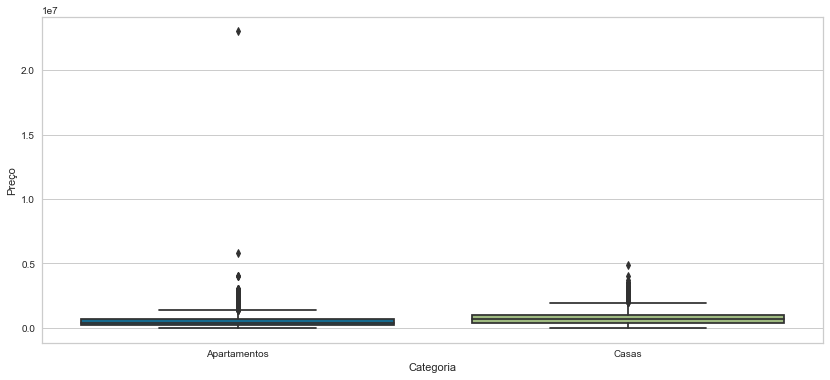

In [65]:
fig = plt.subplots(figsize = (14,6))

sns.boxplot( x='Categoria', y='Preço', data=df );


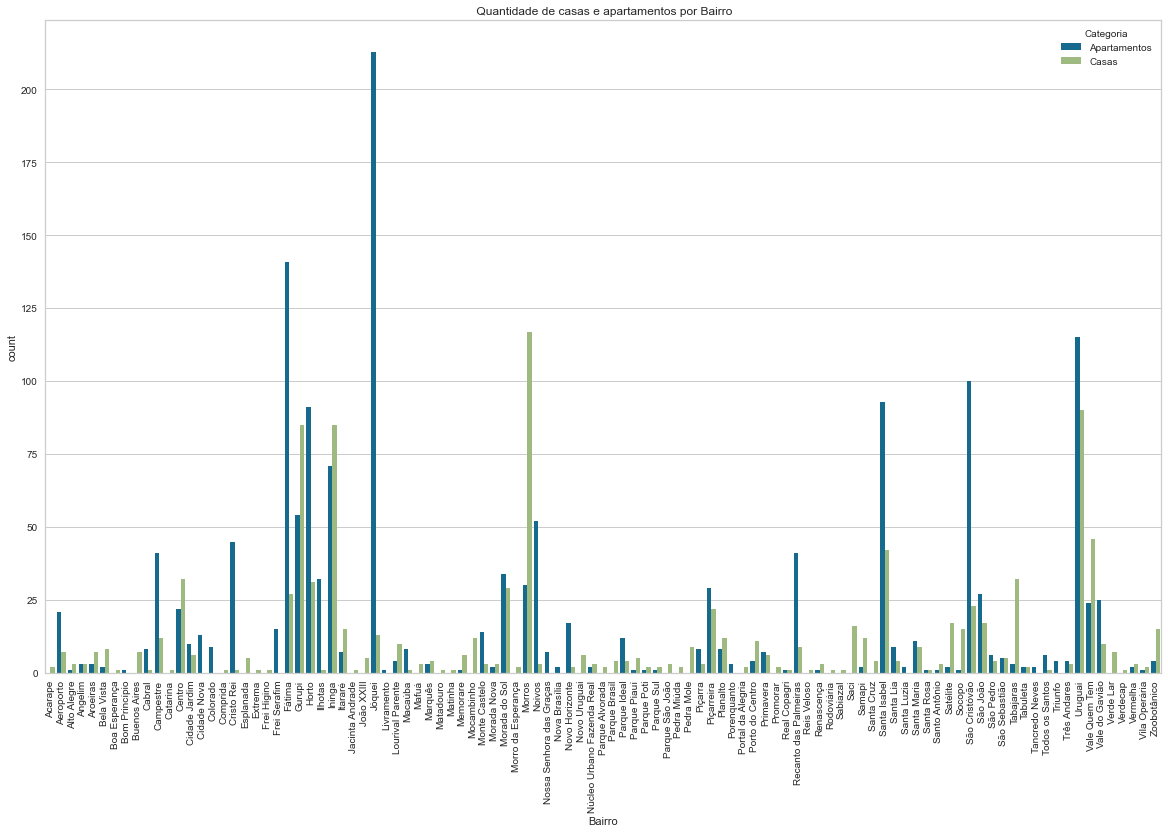

In [66]:
fig = plt.subplots(figsize = (20,12))
sns.countplot(x ='Bairro', hue= 'Categoria',data = df );
plt.title(" Quantidade de casas e apartamentos por Bairro")
plt.xticks(rotation=90);

## 3. Feature Engineering

In [116]:
df1 = df

### 3.1 Mapa Mental de Hipótese

In [68]:
# TODO Imagem

#### 3.2 Criação de Hipoteses

- Bairros mais centrais, os imóveis são mais caros?
- Preços de imóveis  variam de dependendo do bairro
- Quanto mais quartos, mais caro o imóvel?
- Quanto mais banheiros, mais caro o imóvel?
- Casas são mais caras que apartamentos?
- Quanto maior a área construída, maior o preço?
- TODO

### 3.3 Feature Enginnering

In [69]:
# TODO
df[df.Bairro == "Acarape"]

,Categoria,Area construida,Preço,Quartos,Banheiros,Vagas,Bairro,preco_por_metro,zona
1021,Casas,215.0,450000.0,4,2,4,Acarape,2093.0,Norte
1133,Casas,162.0,650000.0,3,2,4,Acarape,4012.0,Norte


In [117]:
 
df1['QuartosporAreaConstruida'] = df1['Quartos'] / df1['Area construida']
df1['LogAreadivBanheiro'] = np.log(df1['Banheiros'] / df1['Area construida'])

# Log das áreas
df1['LogAreaConstruida'] = np.log1p(df1['Area construida'])

In [71]:
df1.shape

(2608, 12)

### 2.5 Filter variables

In [118]:
# Filtra valores preco e area construida com base na statistica
df1 = df1[df.Preço < 3000000][df1['Area construida'] < 800][df1.Preço > 100000]

In [119]:
df1.shape

(2511, 12)

In [110]:
df1[df1.Preço < 100000]

,Categoria,Area construida,Preço,Quartos,Banheiros,Vagas,Bairro,preco_por_metro,zona,QuartosporAreaConstruida,LogAreadivBanheiro,LogAreaConstruida
51,Apartamentos,100.0,0.0,3,2,1,Santa Luzia,0.0,Sul,0.030000,-3.912023,4.615121
106,Apartamentos,49.0,15000.0,2,1,2,Primavera,306.0,Norte,0.040816,-3.891820,3.912023
179,Apartamentos,49.0,90000.0,2,1,1,Lourival Parente,1837.0,Sul,0.040816,-3.891820,3.912023
305,Apartamentos,43.0,35000.0,2,1,1,Novo Horizonte,814.0,na,0.046512,-3.761200,3.784190
406,Apartamentos,43.0,35000.0,2,1,1,Novo Horizonte,814.0,na,0.046512,-3.761200,3.784190
560,Casas,60.0,60000.0,2,1,4,João XXIII,1000.0,na,0.033333,-4.094345,4.110874
694,Casas,300.0,70000.0,3,2,4,São Pedro,233.0,Sul,0.010000,-5.010635,5.707110
988,Casas,400.0,50000.0,1,1,1,Satélite,125.0,Leste,0.002500,-5.991465,5.993961
1043,Casas,36.0,35000.0,1,1,0,Santa Maria,972.0,na,0.027778,-3.583519,3.610918
1283,Casas,209.0,0.0,3,3,2,Sabiazal,0.0,na,0.014354,-4.243722,5.347108


# 3. Análise Exploratória de Dados EDA

### 3.1 Análise Univariada

In [74]:
# TODO

### 3.2 Análise Bivariada

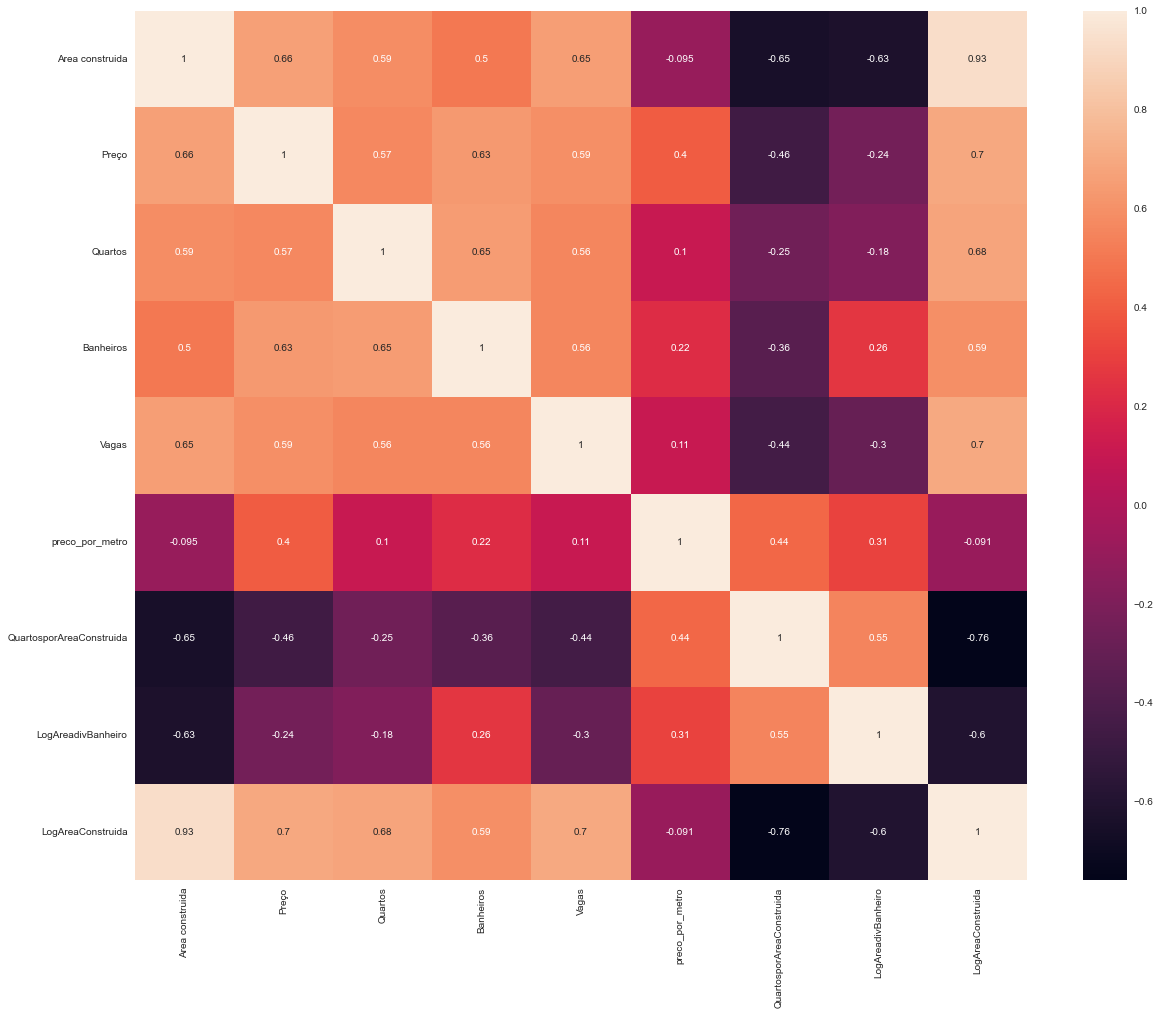

In [121]:
num = df1.select_dtypes( include=['int32', 'float64'] )

fig = plt.subplots(figsize = (20,16))

correlation = num.corr( method='pearson' )
sns.heatmap( correlation, annot=True );
plt.show();

In [122]:
for coluna in df1.columns:
    print(coluna.upper())
    grafico = px.histogram(df1, x=coluna, color="Categoria");
    grafico.show()

CATEGORIA


AREA CONSTRUIDA


PREÇO


QUARTOS


BANHEIROS


VAGAS


BAIRRO


PRECO_POR_METRO


ZONA


QUARTOSPORAREACONSTRUIDA


LOGAREADIVBANHEIRO


LOGAREACONSTRUIDA


### 3.2.1 H. Preços de imóveis  variam de dependendo do bairro
**VERDADEIRA**

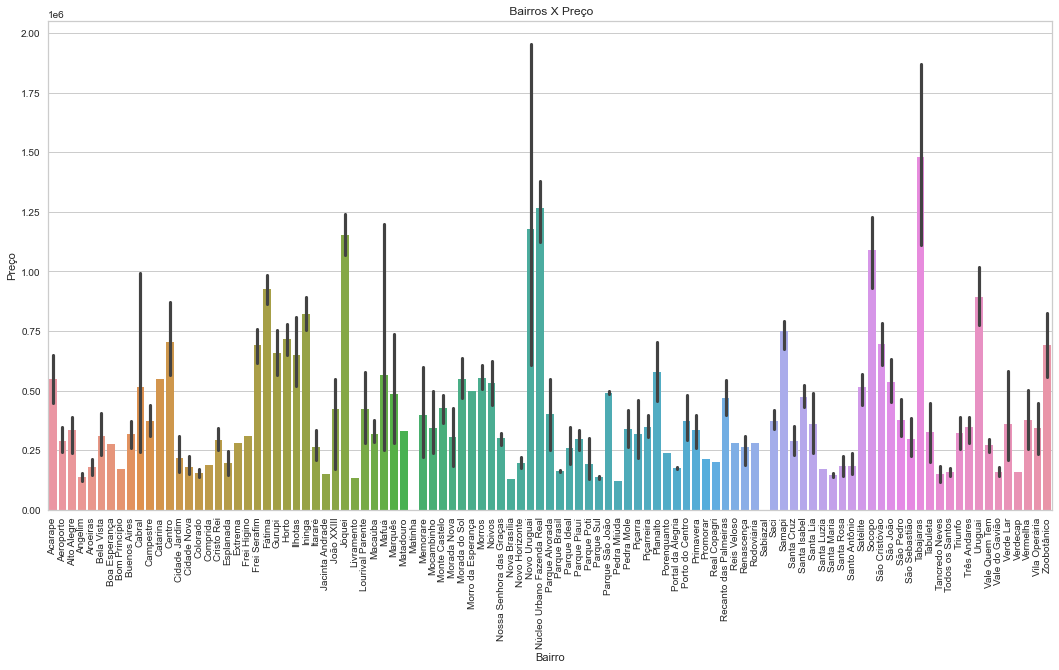

In [123]:
fig = plt.subplots(figsize = (18,9))

sns.barplot( x='Bairro', y='Preço', data=df1);
plt.title(" Bairros X Preço");
plt.xticks(rotation=90);

### 3.3.2 H. - Quanto mais quartos, mais caro o imóvel?
**FALSO** Imóveis de 1 dorm são mais caros que de 2 dorm , imóveis de 4 e 5 dorm menor variação de preço

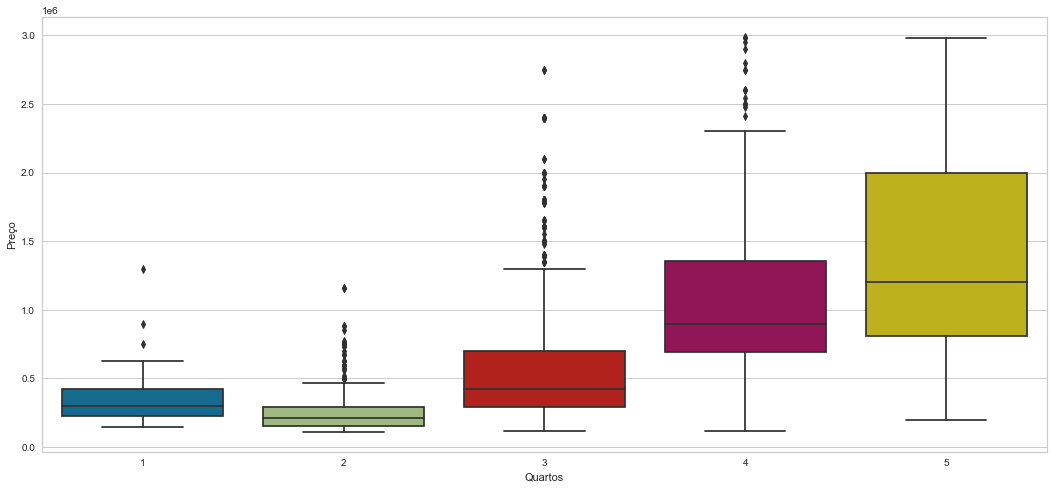

In [124]:
fig = plt.subplots(figsize = (18,8))

sns.boxplot( x='Quartos', y='Preço', data=df1);


### 3.3.3 H.- Quanto mais banheiros, mais caro o imóvel?
**VERDADEIRO**


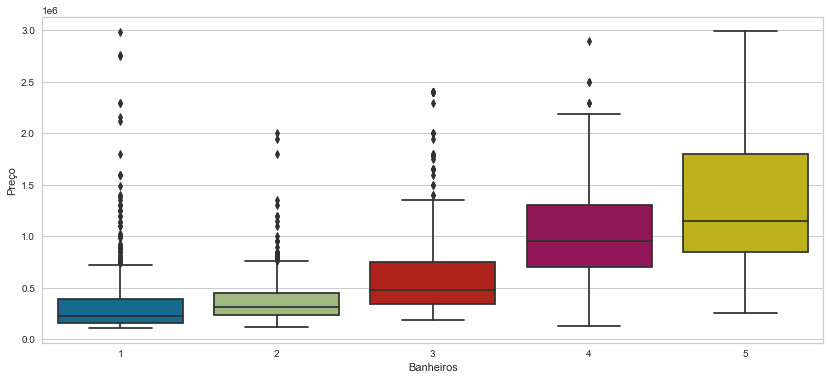

In [125]:
fig = plt.subplots(figsize = (14,6))
sns.boxplot( x='Banheiros', y='Preço', data=df1);


### 3.3.4 H. - Quanto maior a área construída, maior o preço?
**FALSO**


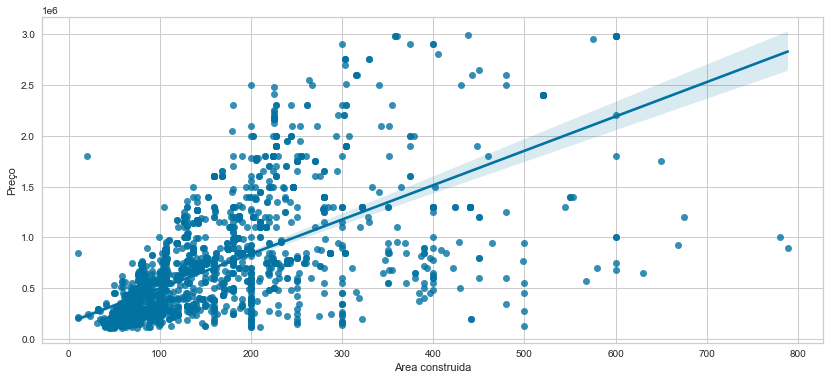

In [126]:
fig = plt.subplots(figsize = (14,6))
sns.regplot( x ='Area construida', y='Preço', data=df1);

### 3.3.4 H. - Casas são mais caras que apartamentos?
**VERDADEIRO**


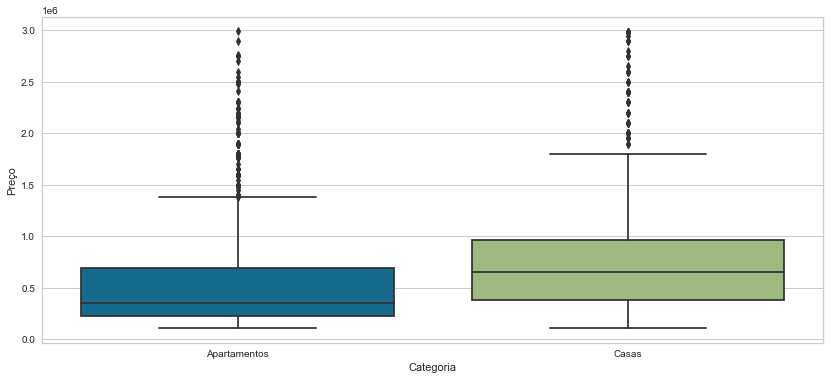

In [127]:
fig = plt.subplots(figsize = (14,6))

sns.boxplot( x='Categoria', y='Preço', data=df1 );

# DÚVIDAS, GALERA:

## SERÁ QUE É NECESSÁRIO FAZER A VALIDAÇÂO ESTATÌSTICA????

## A PREPARAÇÃO (transofrmação) ANTES OU DEPOIS DA SEPARACAO ? para não ´passar` info 

# se depois separar em treino, teste e validation antes 

# 4. DATA PREPARATION

In [164]:
df2 = df1.copy()

## 4.1 Normalização

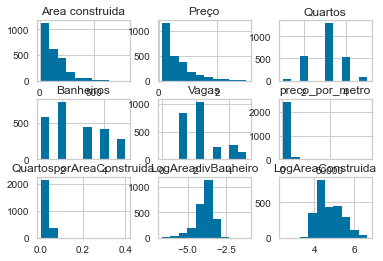

In [165]:
df2.hist();

In [160]:
df2.columns

Index(['Categoria', 'Area construida', 'Preço', 'Quartos', 'Banheiros',
       'Vagas', 'Bairro', 'preco_por_metro', 'zona',
       'QuartosporAreaConstruida', 'LogAreadivBanheiro', 'LogAreaConstruida'],
      dtype='object')

## 4.2 Rescalling

In [166]:
rs = RobustScaler()

df2['Area construida'] = rs.fit_transform( df2[['Area construida']].values )
df2['QuartosporAreaConstruida'] = rs.fit_transform( df2[['QuartosporAreaConstruida']].values )


## 4.3 Transformation


### 4.3.1 Encoding

In [168]:
# BAirro e Categoria - Label Encoding
le = LabelEncoder()
df2['Bairro'] = le.fit_transform( df2['Bairro'] )
#pickle.dump( le, open( 'parametros/bairro_scaler.pkl', 'wb') )
df2['zona'] = le.fit_transform( df2['zona'] )

                                      
df2['Categoria'] = le.fit_transform(df2.Categoria)   
#pickle.dump( le, open( 'parametros/categoria_scaler.pkl', 'wb') )
                                     


In [169]:

df2.head(2)

,Categoria,Area construida,Preço,Quartos,Banheiros,Vagas,Bairro,preco_por_metro,zona,QuartosporAreaConstruida,LogAreadivBanheiro,LogAreaConstruida
0,0,0.901639,1100000.0,3,4,4,22,5238.0,1,-0.698033,-3.960813,5.351858
1,0,-0.409836,115000.0,2,1,1,95,2300.0,1,0.558426,-3.912023,3.931826


### 4.3.2 Response Variable Transformation

In [170]:
#transf. logarítma 0 grande variação (range) de preço
df2['Preço'] = np.log1p( df2.Preço)

### Inferência

In [205]:
# VIF Análise de multicolinearidade '- Inferencia'
df_vif = df2.dropna()
lr_vars = ['Area construida', 'Quartos', 'Banheiros','Categoria',
       'Vagas', 'Bairro', 'QuartosporAreaConstruida','LogAreaConstruida', 'LogAreadivBanheiro']

vif = calc_vif(df_vif[lr_vars])
print('Variable Inflation Factors:', vif.VIF.sum(), '\n')
vif

Variable Inflation Factors: 2699.853566712915 



,variables,VIF
0,Area construida,2.938560
1,Quartos,41.939154
2,Banheiros,104.842745
3,Categoria,2.588984
4,Vagas,9.425760
5,Bairro,3.881813
6,QuartosporAreaConstruida,2.042521
7,LogAreaConstruida,1574.302750
8,LogAreadivBanheiro,957.891279


In [213]:
lr_vars = [
 'Bairro',
 'Categoria',
'Vagas',
'QuartosporAreaConstruida']
plot_vif(calc_vif(df_vif[lr_vars]))

vars:  ['variables', 'VIF']
Variable Inflation Factors: 9.261616393149524 



In [233]:
lr_vars = [
 'Bairro',
 'LogAreadivBanheiro',
'QuartosporAreaConstruida']
plot_vif(calc_vif(df_vif[lr_vars]))

vars:  ['variables', 'VIF']
Variable Inflation Factors: 8.567060143465943 



In [235]:
lr_vars = [
 'Bairro',
 'Banheiros',
'Categoria',
'QuartosporAreaConstruida']
plot_vif(calc_vif(df_vif[lr_vars]))

vars:  ['variables', 'VIF']
Variable Inflation Factors: 8.575604800482202 



In [236]:
# Montando a formula da regressao linear
formula ="Preço ~ " + ' + '.join(lr_vars)
print('formula: ', formula)

# Criando o modelo de regressão linear
model = smf.ols(formula = formula, data = df2).fit()

# Plotando o sumario do modelo
print(model.summary())

formula:  Preço ~ Bairro + Banheiros + Categoria + QuartosporAreaConstruida
                            OLS Regression Results                            
Dep. Variable:                  Preço   R-squared:                       0.567
Model:                            OLS   Adj. R-squared:                  0.567
Method:                 Least Squares   F-statistic:                     821.7
Date:                Mon, 19 Sep 2022   Prob (F-statistic):               0.00
Time:                        22:10:46   Log-Likelihood:                -1821.9
No. Observations:                2511   AIC:                             3654.
Df Residuals:                    2506   BIC:                             3683.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

# 5. FEATURE SELECTION

In [174]:
df3 = df2.copy()

### 5.1 EDA Feature Selector

In [175]:
eda_selection = ['Categoria','Area construida', 'Quartos', 'Banheiros',
       'Vagas', 'Bairro','QuartosporAreaConstruida','LogAreadivBanheiro', 'LogAreaConstruida']

### 5.2 Boruta as Feature Selector

In [176]:
## training and test dataset for Boruta
X_train_n = df3.drop(["Preço", "preco_por_metro"], axis=1).values
y_train_n = df3.Preço.values.ravel()
#
## define RandomForestRegressor
rf = RandomForestRegressor( n_jobs=-1 )
#
## define Boruta
boruta = BorutaPy( rf, n_estimators='auto', verbose=2, random_state=42 ).fit( X_train_n, y_train_n )

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	10
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	10
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	10
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	10
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	10
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	10
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	10
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	9
Tentative: 	0
Rejected: 	1


BorutaPy finished running.

Iteration: 	9 / 100
Confirmed: 	9
Tentative: 	0
Rejected: 	1


In [177]:
cols_selected = boruta.support_.tolist()
cols_selected
#
## best features
X_train_fs = df3.drop(["Preço", "preco_por_metro"], axis=1)
cols_selected_boruta = X_train_fs.iloc[:, cols_selected].columns.to_list()

cols_selected_boruta


['Categoria',
 'Area construida',
 'Banheiros',
 'Vagas',
 'Bairro',
 'zona',
 'QuartosporAreaConstruida',
 'LogAreadivBanheiro',
 'LogAreaConstruida']

### 5.2 Shapiro - Feature Importance


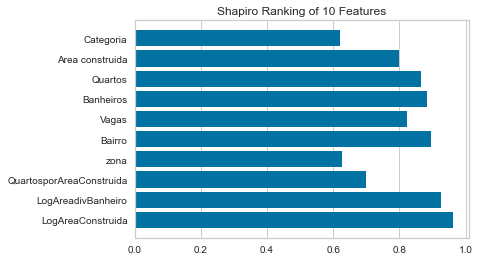

In [178]:
X_train_shapiro = df3.drop(["Preço", "preco_por_metro"], axis=1)
y_train_shapiro= df3.Preço
#
visualizer = Rank1D(algorithm='shapiro')

visualizer.fit(X_train_shapiro, y_train_shapiro)           

visualizer.transform(X_train_shapiro)        
visualizer.show();


### FINAL FEATURE SELECTION

In [179]:
# ?????


In [199]:
selection = ['Categoria','Area construida', 'Banheiros', 'Vagas',
       'Bairro', 'QuartosporAreaConstruida', 'LogAreaConstruida', 'zona',
       'LogAreadivBanheiro']

## 5.1. Split dataframe into training and test dataset

In [200]:
X = df3[selection]
y = df3.Preço

In [201]:
# dividindo em treino, teste e validation
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1) # 0.25 x 0.8 = 0.2

In [202]:
X_train.shape


(1506, 9)

In [203]:
y_val.shape

(502,)

# 6. MACHINE LEARNING MODELLIG

MAE: erro absoluto médio.  abs(y – yhat)/ n  
         Soma de todos os valores reais  menos (–) os  valores previstos -desconsiderando o sinal- valores absolutos- dividido pelo nr total de valores  . Usado para report

MAPE: como o MAE mas em porcentual (usado para report)
    Como é dividido pelo y -para dar o percentual-, não pode haver (y) valores igual a 0.

RMSE:  ao inves de usar abs , ele faz o potencial de( y -yhat)2 e depois tira a raiz, isso é bom pois lida melhor com os outliers, salienta. (usado para medir performance onde onde a precisão é muito importante, por exemplo predição de doença, exames.
MPE : ele não usa o valor absoluto, então ele cancela os erros (um valor negativo e outro positivo). Não utilizado para analisar performance, somente para saber se o modelo está superestimando ou subestimando.Não pode ser usado quando o y for 0


### 6.1.  Linear Regression Model

In [204]:
# model
lr = LinearRegression().fit( X_train, y_train )

# prediction
yhat_lr = lr.predict( X_test )

# performance
lr_result = ml_error( 'Linear Regression', np.expm1( y_test ), np.expm1( yhat_lr ) )
lr_result


,Model Name,MEAN,MEAN_yhat,R2,MAE,MAPE,RMSE
0,Linear Regression,655113.753479,612712.633297,0.612445,210818.214315,0.323245,347689.814578


In [186]:
np.expm1(y_test)

1213     575000.0
570     1550000.0
2638     850000.0
1576     350000.0
2369    1300000.0
          ...    
1614     470000.0
1378     435000.0
2431     288100.0
1329    1350000.0
1869    2750000.0
Name: Preço, Length: 503, dtype: float64

In [187]:
np.expm1(yhat_lr)

array([ 766993.49672487, 1938715.73505702, 1409793.92849262,
        523104.57837176, 1546068.28155451,  595572.17288891,
        782281.79797683,  294490.94607157,  813225.50976635,
        996739.67350517, 1810667.61240458,  195018.80599006,
        318279.41209228,  582652.79158151,  335252.61016622,
        216457.9233711 ,  297808.40092957,  348921.52760993,
        290089.78473136,  571021.84291342,  523141.8605842 ,
        352077.03428183,  704932.90791767,  459719.42864808,
        195687.63919686,  297808.40092957,  311266.2689011 ,
        424961.44420643, 1226731.97371501,  582652.79158151,
        266699.14056398,  442076.84335183,  998468.25661942,
        247497.2995231 ,  319641.80403097,  827771.23962684,
        396015.63454969,  352993.562197  ,  523699.19194379,
        369286.19760392,  285705.88243976,  377319.22959581,
        430688.47498395,  682009.48422161,  439158.23468331,
        320299.09516601,  810498.56173185, 1441912.81624273,
        849412.5514087 ,

#### 6.1.1 Linear Regression Model - CROSS VALIDATION

In [259]:
lr_result_cv = cross_validation_report(X_train, y_train, lr, 'Linear Regression', 5)
lr_result_cv


[0    186630.623558
Name: MAE, dtype: float64, 0    179919.799588
Name: MAE, dtype: float64, 0    196098.357506
Name: MAE, dtype: float64, 0    200270.723312
Name: MAE, dtype: float64, 0    189085.201006
Name: MAE, dtype: float64]


,Model Name,MEAN CV,MEAN PRED CV,R2 CV,MAE CV,MAPE CV,RMSE CV
0,Linear Regression,623176.96 +/- 14536.76,581130.21 +/- 5135.19,0.62 +/- 0.03,190400.94 +/- 7150.86,0.32 +/- 0.02,315670.9 +/- 20515.15


## 6.2. Linear Regression Regularized Model - Lasso

In [189]:
# model
lr_lasso = Lasso( alpha=0.01 ).fit( X_train, y_train )

# prediction
yhat_lr_lasso = lr_lasso.predict( X_test )

# performance
lrr_result = ml_error( 'Linear Regression - Lasso', np.expm1( y_test ), np.expm1( yhat_lr_lasso ) )
lrr_result



,Model Name,MEAN,MEAN_yhat,R2,MAE,MAPE,RMSE
0,Linear Regression - Lasso,655113.753479,596633.704366,0.577202,218905.606025,0.333064,363154.527483


#### Cross Validation

In [261]:
lrr_result_cv =  cross_validation_report(X_train, y_train, lr_lasso, 'Lasso', 5)
lrr_result_cv

[0    198298.263304
Name: MAE, dtype: float64, 0    189396.789304
Name: MAE, dtype: float64, 0    201332.29736
Name: MAE, dtype: float64, 0    207011.120502
Name: MAE, dtype: float64, 0    204072.955874
Name: MAE, dtype: float64]


,Model Name,MEAN CV,MEAN PRED CV,R2 CV,MAE CV,MAPE CV,RMSE CV
0,Lasso,623176.96 +/- 14536.76,572040.5 +/- 6933.83,0.59 +/- 0.04,200022.29 +/- 6047.17,0.33 +/- 0.02,329551.44 +/- 22794.34


## 6.3.Random Forest Regression 

In [191]:
# model
rf = RandomForestRegressor( n_estimators=100, n_jobs=-1, random_state=42 ).fit( X_train, y_train )
# prediction
yhat_rf = rf.predict( X_test )

# performance
rf_result = ml_error( 'Random Forest Regressor', np.expm1( y_test ), np.expm1( yhat_rf ) )
rf_result

,Model Name,MEAN,MEAN_yhat,R2,MAE,MAPE,RMSE
0,Random Forest Regressor,655113.753479,640195.738699,0.82416,119118.791542,0.208498,234198.309134


#### Cross Validation

In [262]:
rf_result_cv = cross_validation_report(X_train, y_train, rf, 'Random Forest Regressor', 5)
rf_result_cv

[0    112182.441013
Name: MAE, dtype: float64, 0    118765.360327
Name: MAE, dtype: float64, 0    128997.497046
Name: MAE, dtype: float64, 0    158196.287421
Name: MAE, dtype: float64, 0    149457.272736
Name: MAE, dtype: float64]


,Model Name,MEAN CV,MEAN PRED CV,R2 CV,MAE CV,MAPE CV,RMSE CV
0,Random Forest Regressor,623176.96 +/- 14536.76,607612.63 +/- 12880.51,0.77 +/- 0.05,133519.77 +/- 17642.9,0.23 +/- 0.03,242690.37 +/- 30554.17


In [193]:
# model
model_xgb = xgb.XGBRegressor( objective='reg:squarederror',
                              n_estimators=100, 
                              eta=0.01, 
                              max_depth=10, 
                              subsample=0.7,
                              colsample_bytee=0.9 ).fit( X_train, y_train )

# prediction
yhat_xgb = model_xgb.predict( X_test )

# performance
xgb_result = ml_error( 'XGBoost Regressor', np.expm1( y_test ), np.expm1( yhat_xgb ) )
xgb_result

[21:49:39] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "colsample_bytee" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




,Model Name,MEAN,MEAN_yhat,R2,MAE,MAPE,RMSE
0,XGBoost Regressor,655113.753479,4937.892578,-1.351285,650175.860873,0.988852,856402.439397


In [194]:
modelling_result = pd.concat( [lr_result, lrr_result, rf_result, xgb_result] )
modelling_result.sort_values( 'RMSE' )

,Model Name,MEAN,MEAN_yhat,R2,MAE,MAPE,RMSE
0,Random Forest Regressor,655113.753479,640195.738699,0.824160,119118.791542,0.208498,234198.309134
0,Linear Regression,655113.753479,606411.059929,0.612187,212070.189941,0.323231,347805.465287
0,Linear Regression - Lasso,655113.753479,596633.704366,0.577202,218905.606025,0.333064,363154.527483
0,XGBoost Regressor,655113.753479,4937.892578,-1.351285,650175.860873,0.988852,856402.439397
